In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

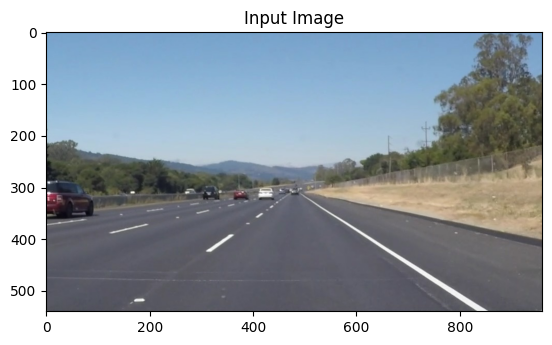

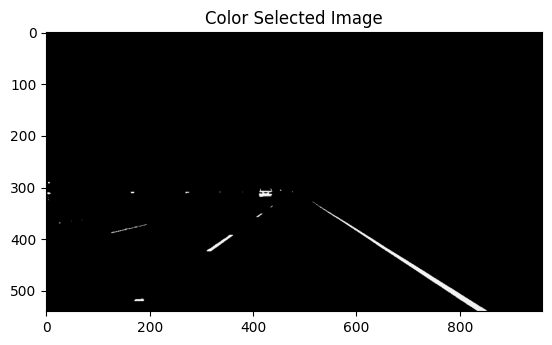

In [2]:
# Read in the image
image = mpimg.imread('/content/drive/MyDrive/LaneDetection/test_images/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

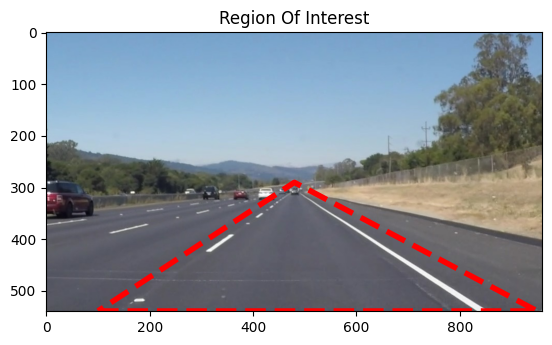

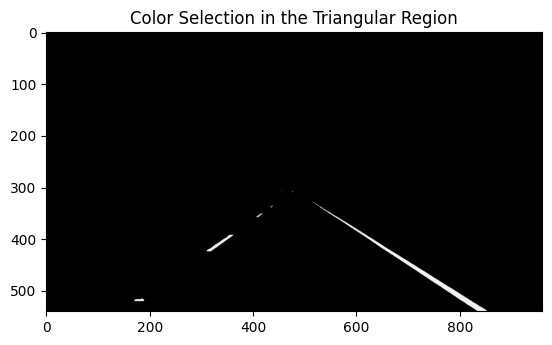

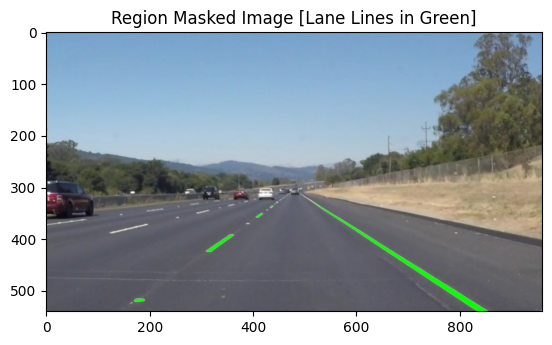

In [3]:
# Read in the image
image = mpimg.imread('/content/drive/MyDrive/LaneDetection/test_images/solidWhiteRight.jpg')

ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
left_bottom = [100, 539]
right_bottom = [950, 539]
apex = [480, 290]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection in the Triangular Region")
plt.show()
plt.imshow(line_image)
plt.title("Region Masked Image [Lane Lines in Green]")
plt.show()

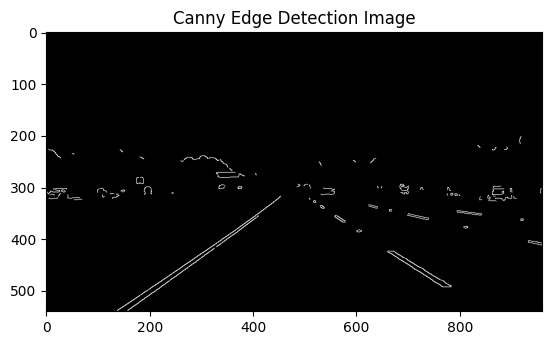

In [4]:
# Read in the image and convert to grayscale
image = mpimg.imread('/content/drive/MyDrive/LaneDetection/test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

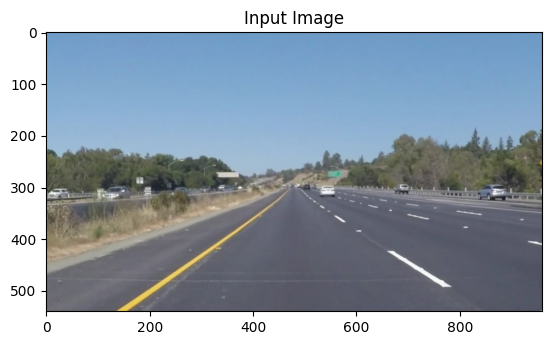

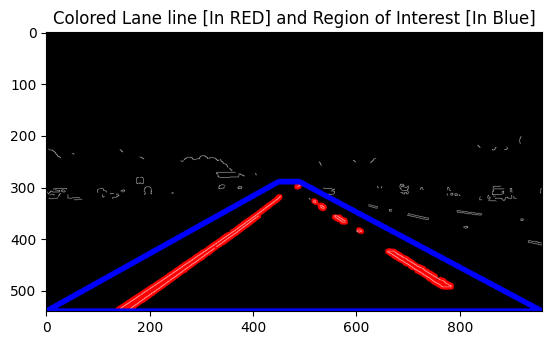

In [5]:
image = mpimg.imread('/content/drive/MyDrive/LaneDetection/test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters

rho = 1 
theta = np.pi/180 
threshold = 2    
min_line_length = 4 
max_line_gap = 5   
line_image = np.copy(image)*0

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)


for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

In [6]:
def grayscale(img):
    #plt.imshow(gray, cmap='gray')
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    if not(left_lines and right_lines):
      return image

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)
    try:
      for slope, intercept in [left_line, right_line]:

          #getting complete height of image in y1
          rows, cols = image.shape[:2]
          y1= int(rows) #image.shape[0]

          #taking y2 upto 65% of actual height or 60% of y1
          y2= int(rows*0.65) #int(0.6*y1)

          #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
          x1=int((y1-intercept)/slope)
          x2=int((y2-intercept)/slope)
          poly_vertices.append((x1, y1))
          poly_vertices.append((x2, y2))
          draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
      
      poly_vertices = [poly_vertices[i] for i in order]
      cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
      return cv2.addWeighted(image,0.7,img,0.4,0.)

    except:
      return img
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    #result_img = initial_img * α + img * β + γ
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*1, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [24]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 200, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

<function matplotlib.pyplot.show(close=None, block=None)>

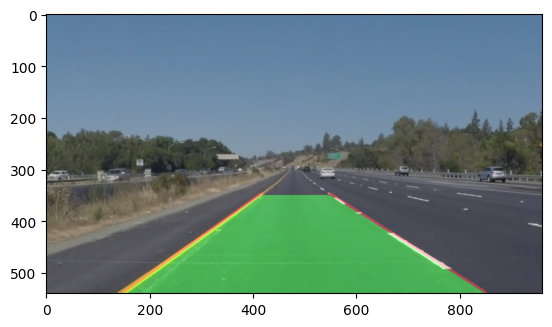

In [25]:
image = mpimg.imread('/content/drive/MyDrive/LaneDetection/test_images/solidYellowLeft.jpg')
plt.imshow(lane_finding_pipeline(image))
plt.show

In [9]:
import os
for image_path in list(os.listdir('/content/drive/MyDrive/LaneDetection/test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'/content/drive/MyDrive/LaneDetection/test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
white_output = './solidwhiteright.mp4'
clip1 = VideoFileClip("/content/drive/MyDrive/LaneDetection/test success/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video ./solidwhiteright.mp4.
Moviepy - Writing video ./solidwhiteright.mp4



Moviepy - Done !
Moviepy - video ready ./solidwhiteright.mp4
CPU times: user 2.98 s, sys: 367 ms, total: 3.35 s
Wall time: 15.3 s


In [11]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(white_output,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 height=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)